In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import utils
import stock_data_fetcher
from stock_plotter import StockPlotter
from models import Models
from model_evaluator import ModelEvaluator
from time_series_visualizer import TimeSeriesVisualizer
from transformer_model import TimeSeriesTransformer
from lstm_transformer_model import LSTMTransformer
from backtest import BacktestStrategy

from matplotlib.backends.backend_pdf import PdfPages

#To get data from yfinance:
ticker = "AAPL"
start = "2020-01-01"
end = "2025-01-01"
interval = "1d"

stock_fetcher = stock_data_fetcher.StockDataFetcher(ticker, start, end, interval)
stock_data = stock_fetcher.fetch_data()

In [2]:
#To get data from pre-loaded csv file 
ticker = "AAPL"
start = "2022-01-01"
end = "2025-01-01"
stock_data = utils.get_csv(ticker, start, end)
print(stock_data.head()) 
print(ticker)

Loaded stock_data_csv\AAPL_2022-01-01_to_2025-01-01.csv successfully!
         Date    Open    High     Low   Close      Volume
0  2024-12-31  252.44  253.28  249.43  250.42  39480718.0
1  2024-12-30  252.23  253.50  250.75  252.20  35557542.0
2  2024-12-27  257.83  258.70  253.06  255.59  42355321.0
3  2024-12-26  258.19  260.10  257.63  259.02  27262983.0
4  2024-12-24  255.49  258.21  255.29  258.20  23234705.0
AAPL


In [3]:
pdf_path = f"results/results_{ticker}_{start}_to_{end}.pdf"
pdf_pages = PdfPages(pdf_path)

df = utils.add_technical_indicators(stock_data)

df_scaled, scaler = utils.prepare_features(df)
sequence_length = 15
X, y = utils.create_sequences(df_scaled[19:], sequence_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'Signal',
       'BB_upper', 'BB_middle', 'BB_lower'],
      dtype='object')


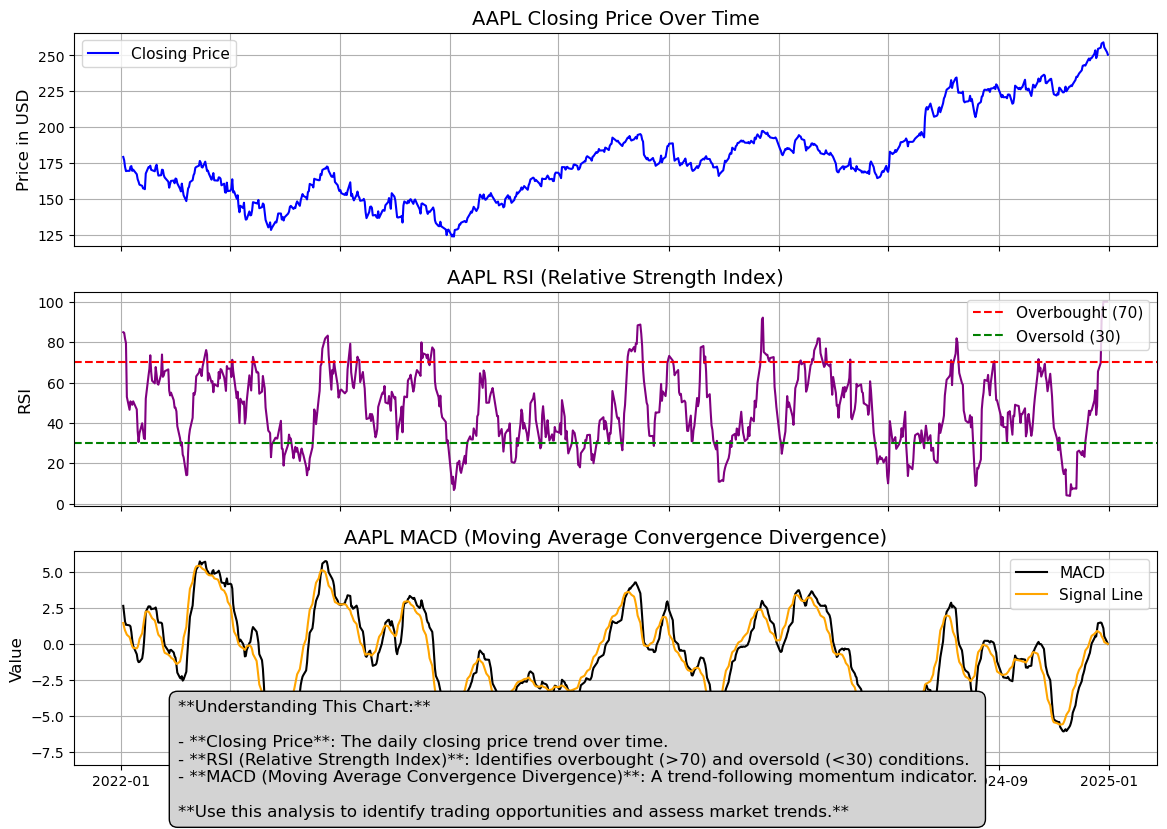

In [4]:
#Draws plot
plotter = StockPlotter(stock_data, ticker)
fig1 = plotter.plot()
pdf_pages.savefig(fig1)  # Save stock plot to PDF

In [5]:
n_features = X_train.shape[2]
lstm_model = Models.LSTM_Model(sequence_length, n_features)
best_params = lstm_model.tune_hyperparameters(X_train, y_train)
history_lstm = lstm_model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.1)
y_pred_lstm = lstm_model.predict(X_test).flatten()

Reloading Tuner from lstm_tuner\lstm_hyperparameter_tuning\tuner0.json
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3914 - val_loss: 0.0428
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0497 - val_loss: 0.0673
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0426 - val_loss: 0.0279
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0286 - val_loss: 0.0276
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0271 - val_loss: 0.0338
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0271 - val_loss: 0.0280
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0260 - val_loss: 0.0265
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0266 - val_loss: 0.0244
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0241 - val_loss: 0.0242
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0230 - val_loss: 0.0239
Epoch 1/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0221 - val_loss: 

In [8]:
xgb_model = Models.XGB_Model(n_estimators=150, max_depth=8, learning_rate=0.05, gamma=0.3, subsample=0.9)

xgb_model.summary()  # ✅ Now the method exists and will print model details

xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)
y_pred_xgb = predictions.flatten()



📌 **XGBoost Model Summary**
 - n_estimators: 150
 - max_depth: 8
 - learning_rate: 0.05
 - Other Parameters: {'gamma': 0.3, 'subsample': 0.9}
 - Model Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.3, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_meth

In [9]:
gp_model = Models.GP_Model()
gp_model.fit(X_train, y_train)

# Predict with confidence intervals
y_pred_gp, sigma_gp = gp_model.predict(X_test, return_std=True)

C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Optimized Kernel: 195**2 * Matern(length_scale=5e+03, nu=1.5) + WhiteKernel(noise_level=1e-09)


C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 5000. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Model: LSTM1
MSE: 0.3449
MAE: 0.4767
R²: 0.9143
Direction: 0.4965

Model: XGBoost
MSE: 0.0040
MAE: 0.0496
R²: 0.9782
Direction: 0.6923

Model: Gaussian Process
MSE: 0.0045
MAE: 0.0519
R²: 0.9758
Direction: 0.6923
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
144


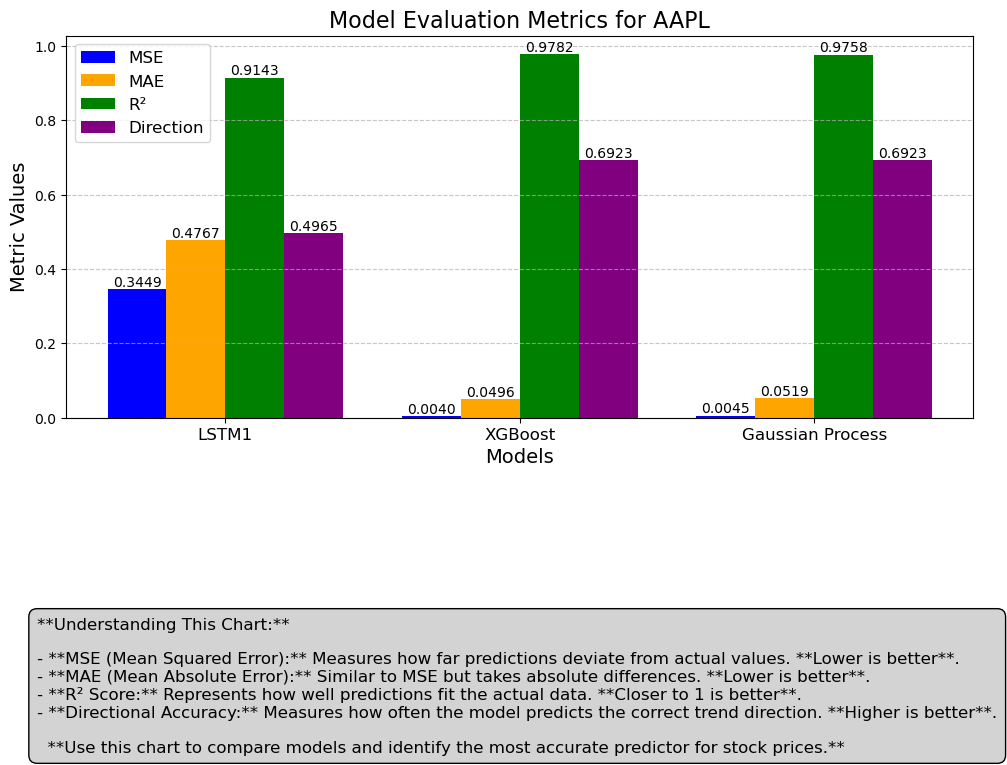

In [10]:
models = {
    'LSTM1': lstm_model,
    'XGBoost': xgb_model,
    'Gaussian Process': y_pred_gp
}
evaluator = ModelEvaluator(models, X_test, y_test, ticker)

# Evaluate models
evaluation_results, y_predictions = evaluator.evaluate()

# Print results
for model, metrics in evaluation_results.items():
    print(f"\nModel: {model}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

fig2 = evaluator.plot_metrics()
pdf_pages.savefig(fig2)
print(len(X_test))

C:\Users\aivis\AppData\Local\Temp\ipykernel_30608\2242802923.py:23: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  pdf_pages.savefig(fig3)
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


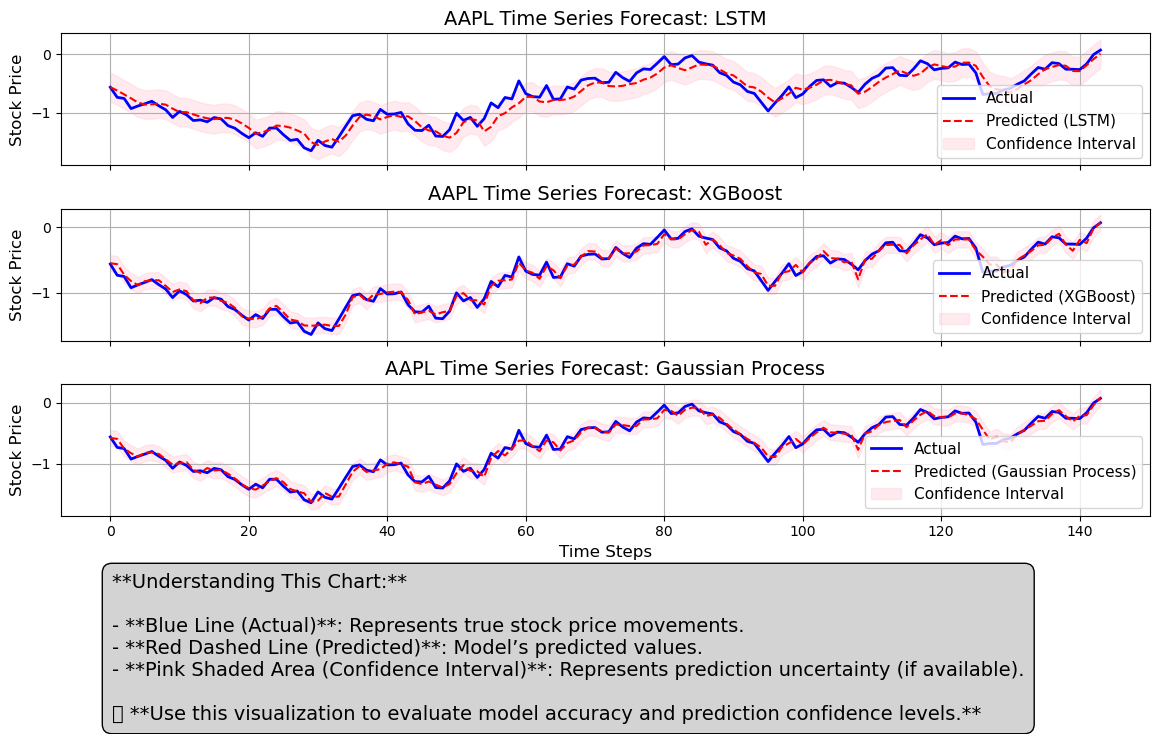

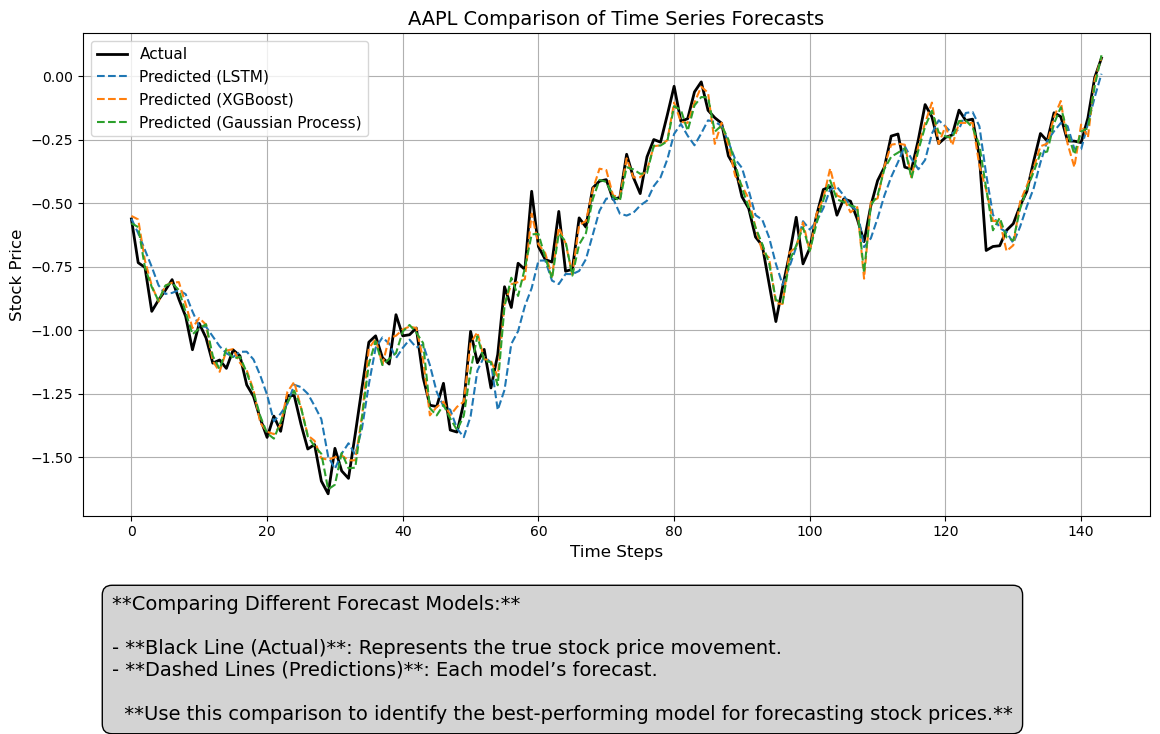

In [11]:
std_devs = {}  # Ensure std_devs exists even if sigma_gp is not available

if 'sigma_gp' in globals():
    std_devs['GP'] = sigma_gp  # Add Gaussian Process std deviation if available# Assuming you have predictions from LSTM, XGBoost, and Gaussian Process
    
'''predictions = {
    'LSTM': y_pred_lstm,
    'XGBoost': y_pred_xgb,
    'Gaussian Prpcess': y_pred_gp,
    'Transformer': y_pred_transformer
}'''
predictions = {
    'LSTM': y_pred_lstm,
    'XGBoost': y_pred_xgb,
    'Gaussian Process': y_pred_gp
}
if 'sigma_gp' in globals():
    std_devs = {'GP': sigma_gp}

visualizer = TimeSeriesVisualizer(y_test, predictions, ticker, std_devs)

fig3 = visualizer.plot_predictions()
pdf_pages.savefig(fig3)
fig4 = visualizer.compare_models()
pdf_pages.savefig(fig4)

In [12]:
backtester = BacktestStrategy(initial_balance=10000, transaction_cost=0.001)

results_lstm = backtester.backtest(y_test, y_pred_lstm, model_name="LSTM")
metrics_lstm = backtester.evaluate_performance(results_lstm)
results_xgb = backtester.backtest(y_test, y_pred_xgb, model_name="XGBoost")
metrics_xgb = backtester.evaluate_performance(results_xgb)
results_gp = backtester.backtest(y_test, y_pred_xgb, model_name="Gaussian Process")
metrics_gp = backtester.evaluate_performance(results_gp)

Backtest for LSTM completed. Final balance: $-840.75

Performance Metrics:
Final Balance: -840.7502
Total Return: -1.0841
Sharpe Ratio: -0.0330
Max Drawdown: 1.0431
Backtest for XGBoost completed. Final balance: $-804.55

Performance Metrics:
Final Balance: -804.5523
Total Return: -1.0805
Sharpe Ratio: -0.0332
Max Drawdown: 1.0431
Backtest for Gaussian Process completed. Final balance: $-804.55

Performance Metrics:
Final Balance: -804.5523
Total Return: -1.0805
Sharpe Ratio: -0.0332
Max Drawdown: 1.0431


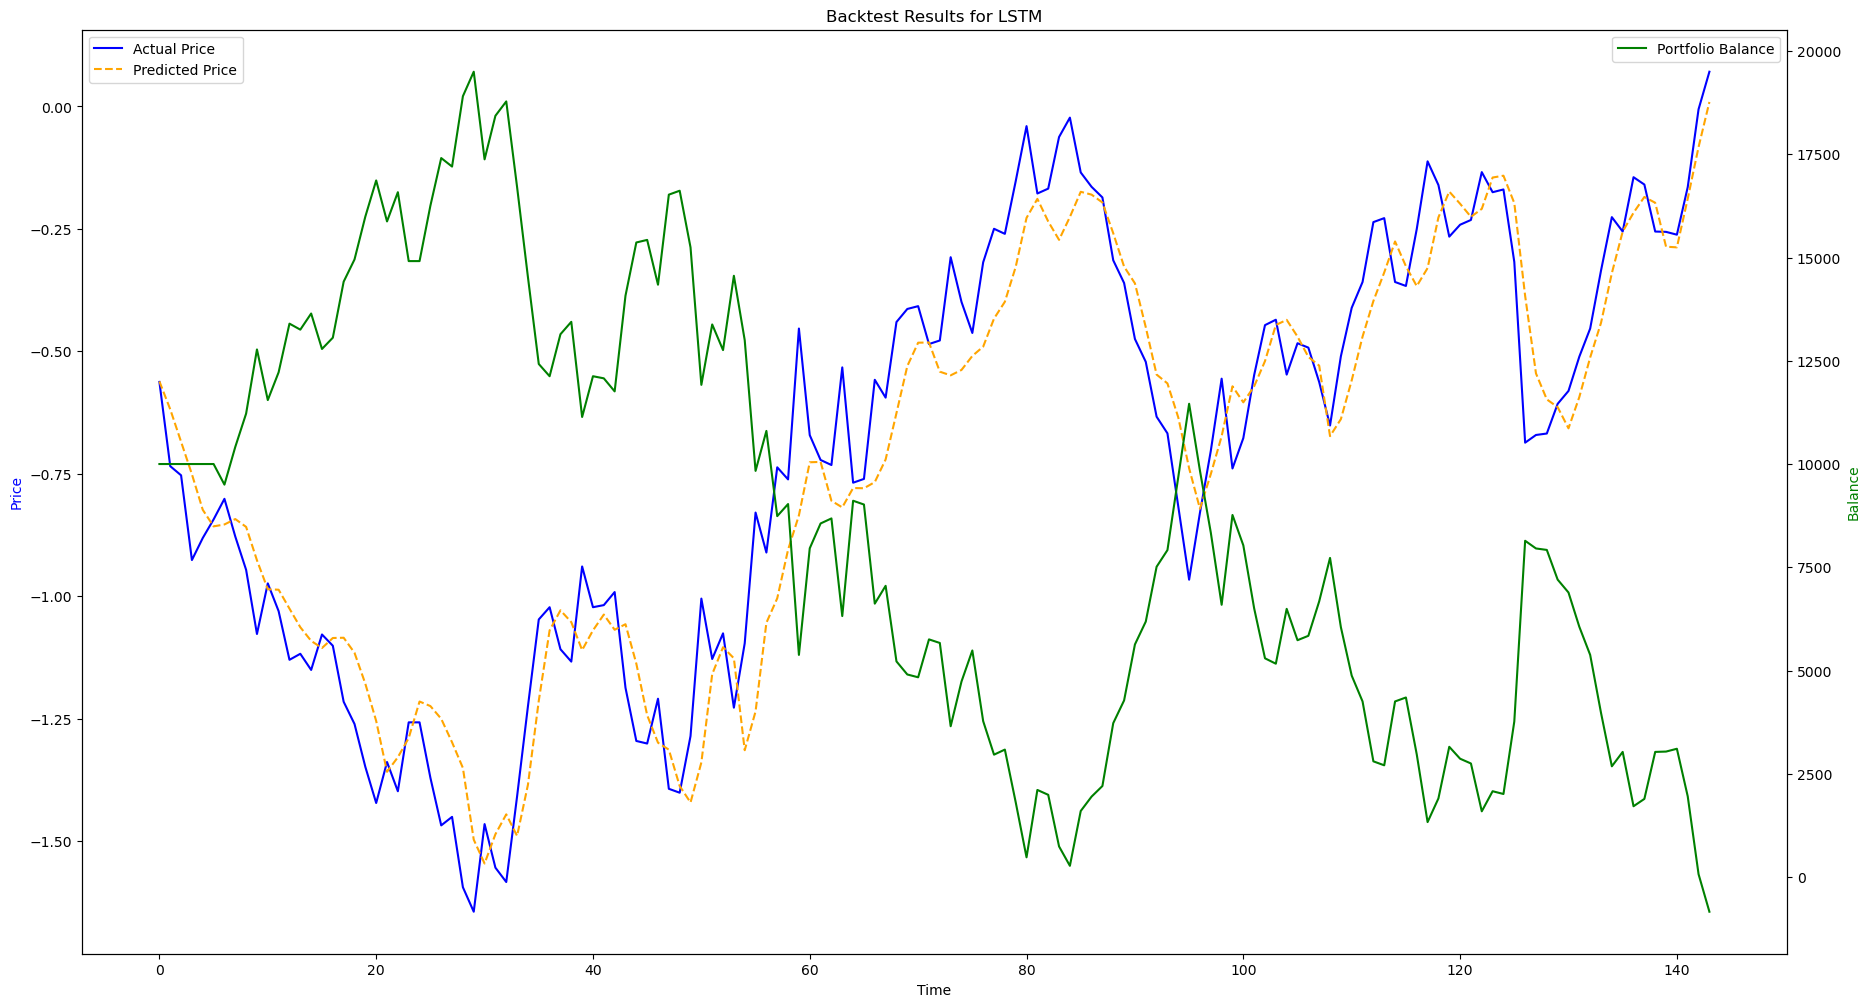

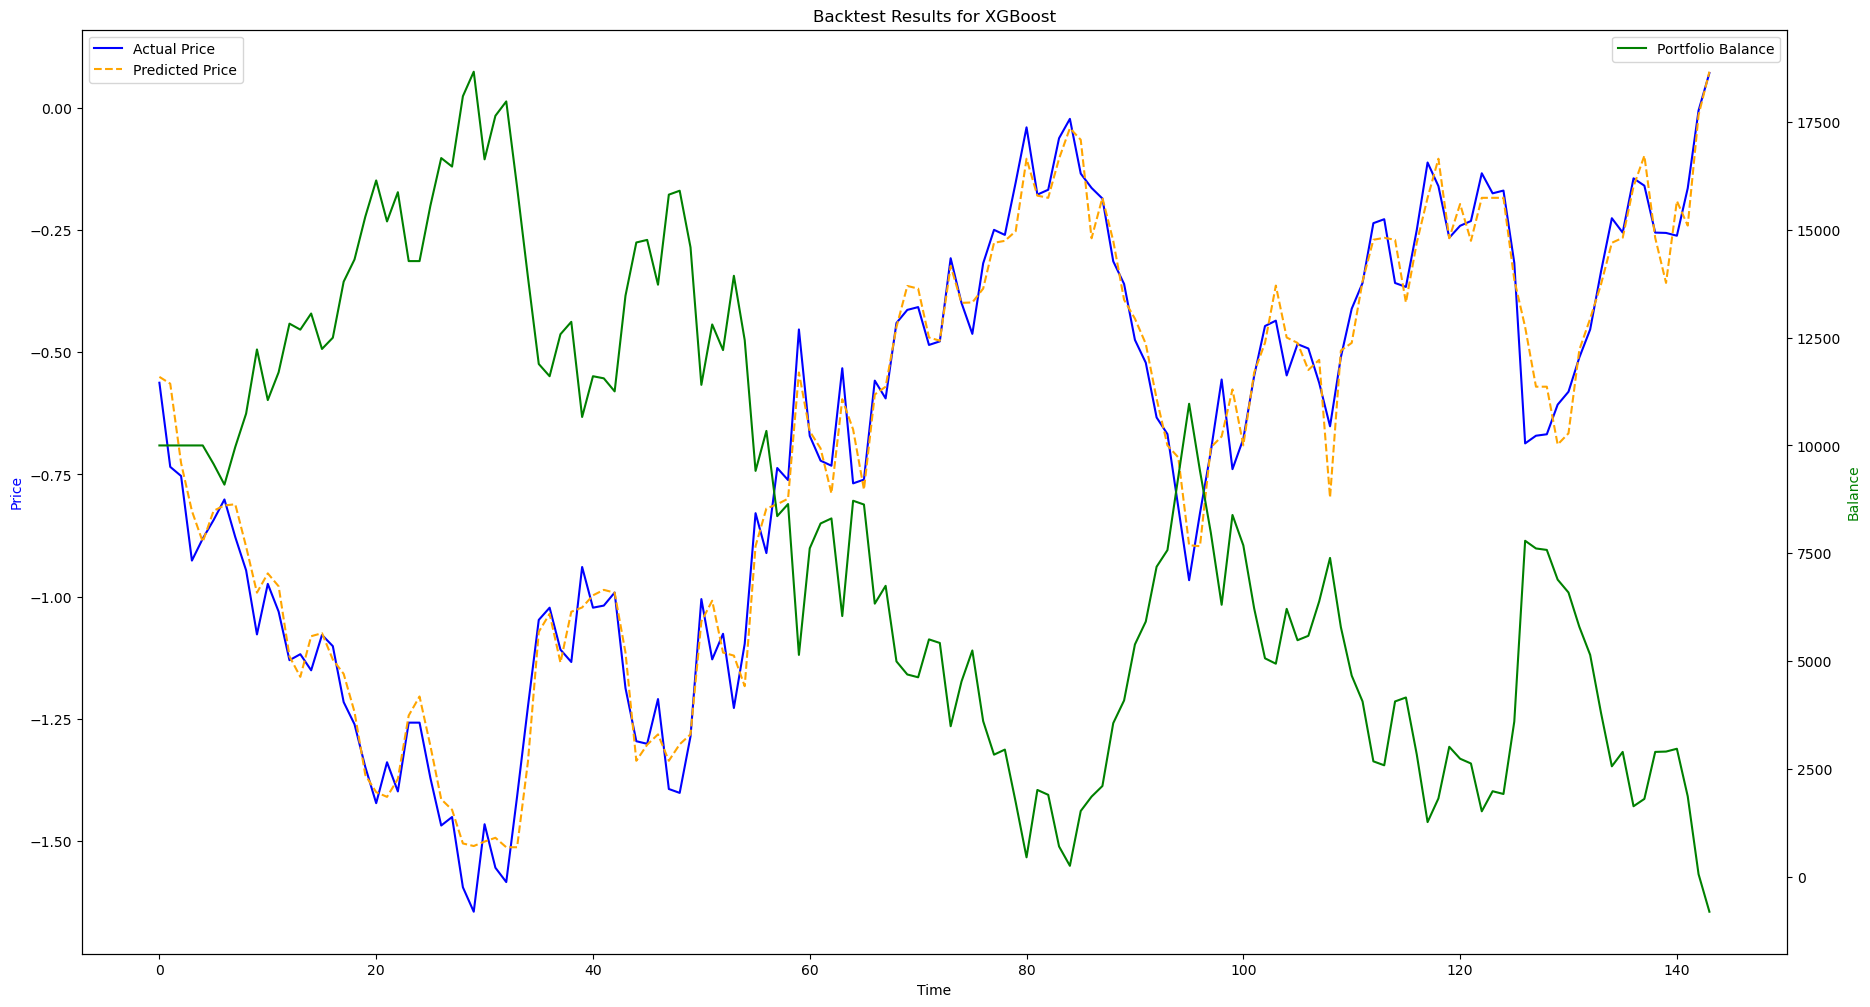

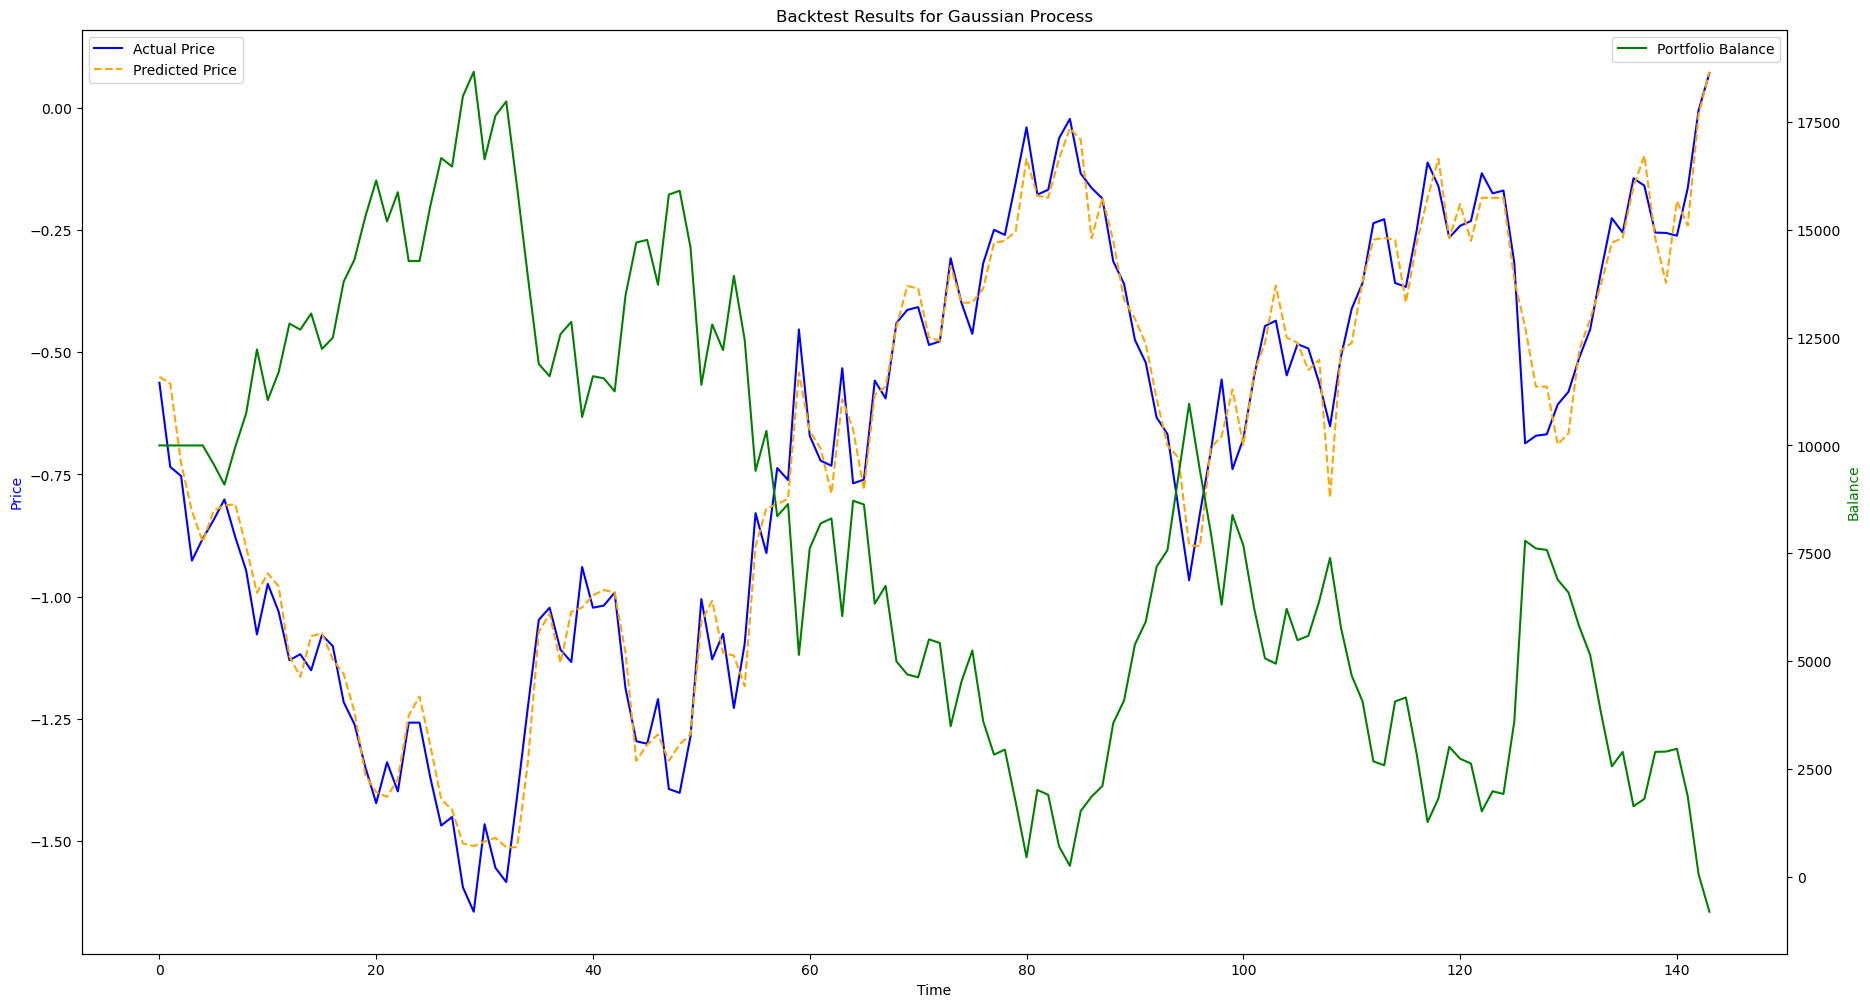

Backtest results saved to PDF.


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Generate individual figures
fig_lstm = backtester.plot_results(results_lstm, model_name="LSTM")
fig_xgb = backtester.plot_results(results_xgb, model_name="XGBoost")
fig_gp = backtester.plot_results(results_gp, model_name="Gaussian Process")

# Save figures to the PDF
pdf_pages.savefig(fig_lstm)
pdf_pages.savefig(fig_xgb)
pdf_pages.savefig(fig_gp)
print("Backtest results saved to PDF.")

Backtest results for LSTM saved to PDF (Page 6).


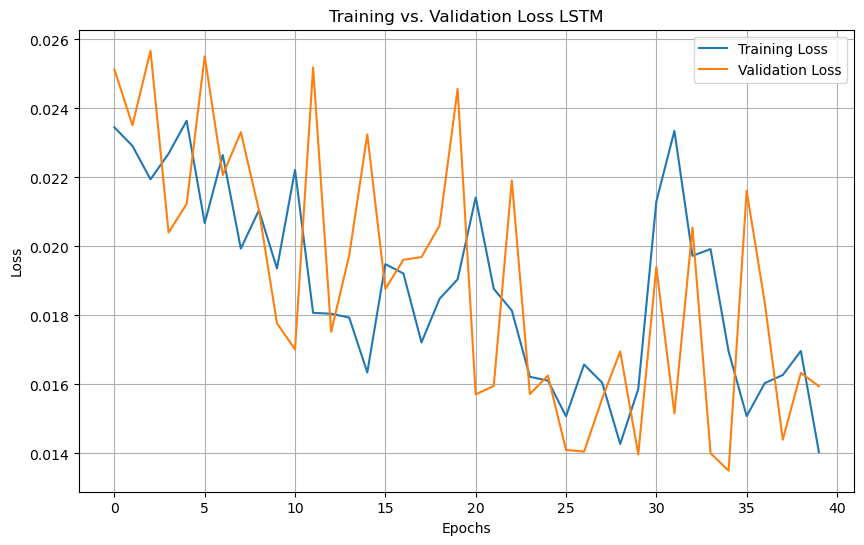

In [14]:
fig6 = utils.plot_training_history(history_lstm)  # Call only once and store result

if fig6 is not None:  # Ensure fig7 is valid before saving
    pdf_pages.savefig(fig6)
    print("Backtest results for LSTM saved to PDF (Page 6).")
else:
    print("Error: plot_training_history did not return a figure.")

Backtest results for XGBoost saved to PDF (Page 7).


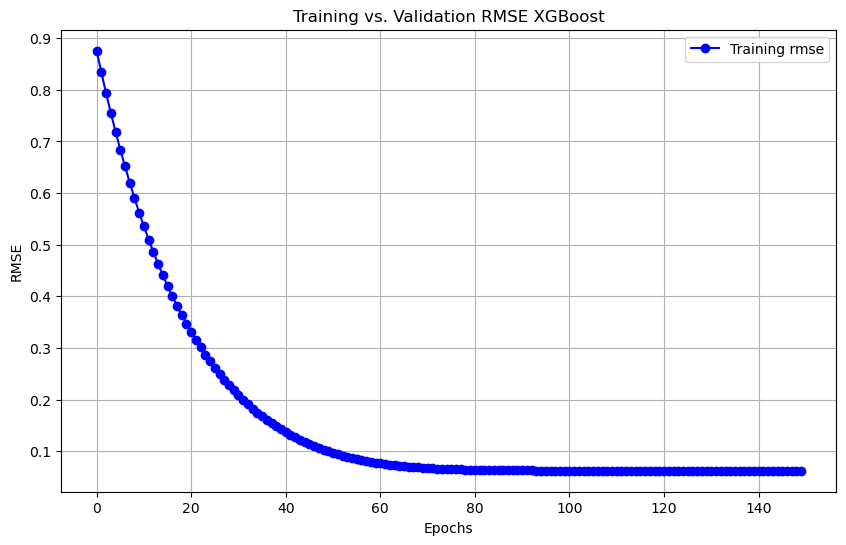

In [15]:
fig7 = xgb_model.plot_training_history(metric="rmse")
#fig7 = utils.plot_training_history(history_lstm)  # Call only once and store result

if fig7 is not None:  # Ensure fig7 is valid before saving
    pdf_pages.savefig(fig7)
    print("Backtest results for XGBoost saved to PDF (Page 7).")
else:
    print("Error: plot_training_history did not return a figure.")

C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 5000. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Optimized Kernel: 192**2 * Matern(length_scale=5e+03, nu=1.5) + WhiteKernel(noise_level=1e-09)


C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 5000. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aivis\anaconda3\envs\tf_env\lib\

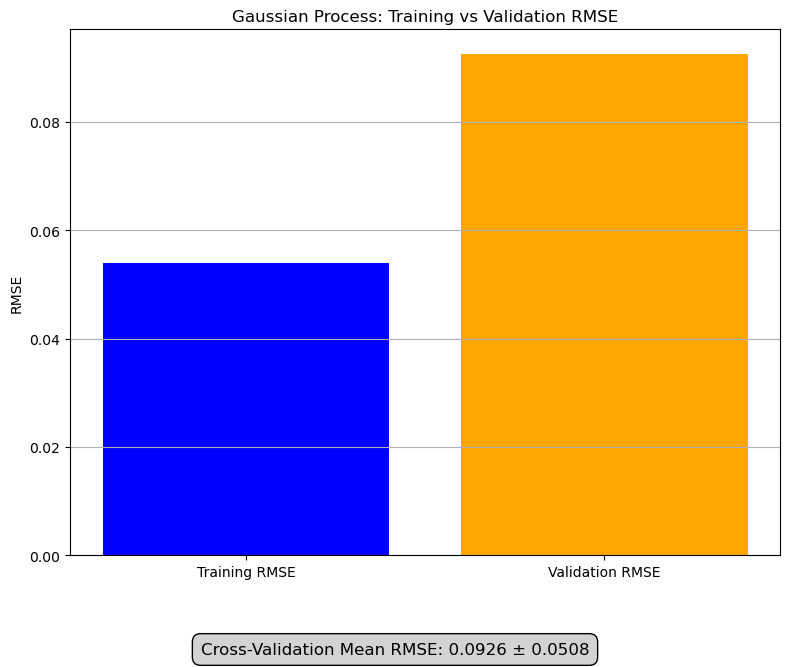

In [16]:
#gp_model = GaussianProcessModel()
fig8 = gp_model.validate(X_train, y_train)
pdf_pages.savefig(fig8)  # ✅ Save to PDF

In [17]:
# Close the PDF file
pdf_pages.close()
print(f"PDF successfully closed")

#Falls nur ein Teill von Code wird ausgefuert und kein pdf erzeugt wird, sonst Fehlermeldung
pdf_pages = PdfPages("output.pdf")

if pdf_pages.get_pagecount() > 0:  # Direkter Vergleich ohne len()
    pdf_pages.close()
else:
    pdf_pages._file.close()  # Datei korrekt schließen, um die Warnung zu vermeiden

PDF successfully closed
